## Compressed Sensing (Non-Uniform-Sampling) of MAT Experiment using Iterative Soft Thresholding

### water and  cyclohexanone on a zeolite

In [1]:

import pylab
import numpy
import scipy
from   scipy import fftpack
from   scipy.fftpack import fft, ifft, hilbert, fftshift, rfft 
import os
import nmrglue

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

%matplotlib inline

### IST Algorithm

In [2]:
def numPeaks( sss ):
    www = numpy.where( sss > 0 )
    numPeaks = 0
    ppp = www[0]
    for i in range(len(ppp[:-1])):
        v = www[0][i]
        v1 = www[0][i+1]
        if v1-v > 1:
            numPeaks +=1

    return( numPeaks ) 



def compressed_sensing_1VD( fid, mask, num_iter=500, factor=0.95, tol = 0.01, maxPeaks=2 ):
    
    sss = numpy.zeros( len(fid))
    sss0 = numpy.zeros( len(fid))
    
    final_iter_value  = 0
    final_tol_value   = 0
    final_numpeaks_value = 0

    fid1 = fid.copy()
    tol_diff = (numpy.sqrt(((abs(fid1)).sum())/32.))
    
    k=0
    rrr = fftpack.fft(fid1)
    rss0 = []
    rss0.append(abs(rrr).sum())
    
    tol0 = abs(rrr).sum()
    tol_diff = ( tol0 - abs(rrr).sum() )*100.0 / tol0
    while (tol_diff < tol) and (k < num_iter) and numPeaks( sss ) <maxPeaks:
        
        sss0 = 1.0*sss
        
        rrr = fftpack.fft(fid1)
        m1 = max(rrr.real)
        
        sss_max_old = sss.max()
               
        for i,r in enumerate(rrr):
            if r.real > m1* factor:
                sss[i] = sss[i]+rrr[i].real-m1*factor
                rrr[i] = complex(m1*factor)
        sss_max = sss.max()
        
        rrr_iii = fftpack.hilbert( rrr.real )
        
        rrr = rrr.real + 1j * rrr_iii
        
        fid1 = fftpack.ifft(rrr)
        
        fid1 *= mask
        tol_diff = ( tol0 - abs(rrr).sum() )*100.0 / tol0
        k +=1

    final_iter_value = k
    final_numpeaks_value = numPeaks(sss)
    final_tol_value = tol_diff
    
    return( sss0, [final_iter_value, final_numpeaks_value, final_tol_value ] )

In [3]:
def numPeaks( sss ):
    www = numpy.where( sss > 0 )
    numPeaks = 0
    ppp = www[0]
    for i in range(len(ppp[:-1])):
        v = ppp[i]
        v1 = ppp[i+1]
        if v1-v > 1:
            numPeaks +=1

    return( numPeaks ) 



def compressed_sensing_1D_VI( fid, mask, num_iter=500, factor=0.95, tol = 0.01, maxPeaks=2 ):
    
#    print tol
    sss = numpy.zeros( len(fid))
    
    final_iter_value  = 0
    final_tol_value   = 0
    final_numpeaks_value = 0
    
    tolerance = []
    numberOfpeaks = []
    
    fid1 = fid.copy()
    tol_diff = 1000.0
    
    k=0
    rrr = fft(fid1)
    
#    print "tol_diff",tol_diff
#    print "Num Peaks", numPeaks( sss )
    
    
    while (tol_diff > tol) and (k < num_iter) and numPeaks( sss ) < maxPeaks:
        
        rrr = fft(fid1)
        m1 = max(rrr.real)*factor
               
        for i,r in enumerate(rrr):
            if r.real > m1:
                sss[i] = sss[i]+rrr[i].real-m1
                rrr[i] = complex(m1)
        rrr = rrr.real + 1j * hilbert( rrr.real )
        
        fid1 = ifft(rrr)*mask

        fid00 = ifft(sss+1j*hilbert(sss))*mask
        
        tol_diff = (abs(fid00.real-fid.real)).sum()
        tolerance.append(tol_diff)
        numberOfpeaks.append( numPeaks( sss ))
        k +=1
#        print tol_diff,k,
        

        
    final_iter_value = k
    final_numpeaks_value = numPeaks(sss)
    final_tol_value = tol_diff
    
    return( sss, [final_iter_value, numberOfpeaks, tolerance ] )




### Matplotlib Class to plot 2D NMR spectrum

In [4]:
class TwoD_NMR_MAT_plot:
    
    def __init__(self, exp, pinfo, info, dimensions_ppm=[]):
        
        print exp.shape
        
        self.exp = exp
        self.pinfo = pinfo
        self.info  = info
        
        self.rr,self.cc = exp.shape
        self.X = np.zeros(exp.shape)
        self.Y = np.zeros(exp.shape)
        
        r1=0
        r2=self.rr

        c1=0
        c2=self.cc
        
        print r2,c2
        
        self.create_axes(  pinfo, info, self.rr, self.cc, dimensions_ppm )
          
        self.create_plot_layout(self.dimensions_index)
        
        self.plot_plots()
        

        
    def create_axes( self, pinfo, info, rr,cc, dimensions_ppm):
                
        self.f1_offset_p = pinfo['procs' ]['OFFSET']
        self.f1_sw_hz     = pinfo['procs' ]['SW_p']
        self.f1_omega    = pinfo['procs' ]['SF']
        self.f1_sw_ppm   = self.f1_sw_hz/self.f1_omega
        
        self.f2_offset_p = pinfo['proc2s' ]['OFFSET']
        self.f2_sw_hz     = pinfo['proc2s' ]['SW_p']
        self.f2_omega    = pinfo['proc2s' ]['SF']
        self.f2_sw_ppm   = self.f2_sw_hz/self.f2_omega
        print self.f1_sw_ppm
        
        self.f1 = np.linspace(self.f1_offset_p, self.f1_offset_p-self.f1_sw_ppm,  self.rr)
        self.f2 = np.linspace(self.f2_offset_p, self.f2_offset_p-self.f2_sw_ppm,  self.cc)
        
        self.dw_f1_ppm = self.f1[1]-self.f1[0]
        self.dw_f2_ppm = self.f2[1]-self.f2[0]
        
        for r in range(self.rr):
    
            for c in range( self.cc):
        
                self.Y[r,c] = self.f1[r]
                self.X[r,c] = self.f2[c] 
                
        print dimensions_ppm       
        if dimensions_ppm == []:
            self.dimensions_index = scipy.array([0,self.rr-1,0,self.cc-1])
        else:
            r1 = int( (dimensions_ppm[1]-self.f1_offset_p)/self.dw_f1_ppm)
            r2 = int( (dimensions_ppm[0]-self.f1_offset_p)/self.dw_f1_ppm)
            c1 = int( (dimensions_ppm[2]-self.f2_offset_p)/self.dw_f2_ppm)
            c2 = int( (dimensions_ppm[3]-self.f2_offset_p)/self.dw_f2_ppm)
            
            self.dimensions_index = scipy.array([r1,r2,c1,c2 ])
            
        print "self.dimensions_index", self.dimensions_index
            
        self.Z1 = self.exp[self.dimensions_index[0]:self.dimensions_index[1],self.dimensions_index[2]:self.dimensions_index[3]]
        self.X1 =   self.X[self.dimensions_index[0]:self.dimensions_index[1],self.dimensions_index[2]:self.dimensions_index[3]]
        self.Y1 =   self.Y[self.dimensions_index[0]:self.dimensions_index[1],self.dimensions_index[2]:self.dimensions_index[3]]
        
        
    def create_plot_layout( self, dimensions_index):
        
        print "dimensions_index",dimensions_index
        
        nullfmt   = NullFormatter()         # no labels

        # definitions for the axes
        left, width = 0.1, 0.65
        bottom, height = 0.1, 0.65
        bottom_h = left_h = left+width+0.02

        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom_h, width, 0.2]
        rect_histy = [left_h, bottom, 0.2, height]

        # start with a rectangular Figure
        plt.figure(2, figsize=(6,6))

        self.axScatter = plt.axes(rect_scatter)
        self.axHistx = plt.axes(rect_histx)
        self.axHisty = plt.axes(rect_histy)

# no labels
        self.axHistx.xaxis.set_major_formatter(nullfmt)
        self.axHisty.yaxis.set_major_formatter(nullfmt)
        
        self.axScatter.tick_params(axis='x', labelsize=16)
        self.axScatter.tick_params(axis='y', labelsize=16)
        self.axScatter.set_xlabel('${^1}$H [ppm]',fontsize=16)
        #ax.set_xlim(-60, 60)
        self.axScatter.set_ylabel('${^1}$H [ppm]', fontsize=16)
        
        self.axHistx.axis('off')
        self.axHisty.axis('off')

        f1_start = self.f1[dimensions_index[0]]
        f1_end   = self.f1[dimensions_index[1]]

        f2_start = self.f2[dimensions_index[2]]
        f2_end   = self.f2[dimensions_index[3]]

        self.axScatter.set_ylim( (f1_start, f1_end) )
        self.axScatter.set_xlim( (f2_start, f2_end) )
        
        

    def plot_plots(self):
        
        # the scatter plot:
        cl = np.linspace(self.Z1.max()*0.01, self.Z1.max()*1.1,10)
        print "Z1.shape",self.Z1.shape
        

        sum_f1 = self.Z1.sum(axis=0)
        print "len(sum_f1)",len(sum_f1)
        sum_f2 = self.Z1.sum(axis=1)
        print "len(sum_f2)",len(sum_f2)

        cset = self.axScatter.contour(self.X1, self.Y1, self.Z1,  cl,  colors='red')
        #
        self.axHistx.plot(sum_f1, 'r-')
        self.axHisty.plot(sum_f2,range(len(sum_f2)),'r')


        self.axHistx.set_xlim( (0,len(sum_f1)-1) )
        self.axHisty.set_ylim( (0,len(sum_f2)-1) )        
        
        
        

### Read in Experimental Data

In [5]:


f1=64
zerofill = 512
f2=1024
pp=32


expt_no = "202"  # PGSTE -MAT, 32 scans, D1=1s, 15Hz, 32_64 from 200


#directory = os.path.join("Y:", os.sep,"SSNMR","Backup", "Avance", "NMR","eeh_20150710_4mmHXG_MAT" )
directory = os.path.join( "NMRDATA","eeh_20150710_4mmHXG_MAT" )

file_rrr = os.path.join( directory, expt_no, "pdata", "1")

file_ser = os.path.join(directory,expt_no)
                         
cs_file  = os.path.join( directory,expt_no,"vdlist")
file1    = os.path.join( directory,expt_no,"pdata","1","2rr" )



max_num_peaks = 100
tolerance = 80e3
iterations = 500

In [6]:
pinfo,expt = nmrglue.fileio.bruker.read_pdata( file_rrr )
info,expt_fid = nmrglue.bruker.read( file_ser )

0


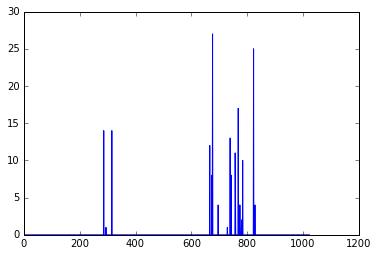

In [7]:
pylab.plot(expt[-1].real);
nus_pts=32
print  ((abs(expt[0][-nus_pts:].real)).sum())

In [8]:
## transfer fid into matrix with dimensions of final FFT spectra

(rr,cc) = expt.shape
expt = numpy.zeros((rr,cc),dtype=numpy.complex128)

(rr,cc) = expt_fid.shape
for r in range(rr):
    for c in range(cc):
        expt[r][c] = expt_fid[r][c]
        
del expt_fid

In [9]:
## read in compressed sensing positions 

cs_array = scipy.fromfile( cs_file, sep = " " )
cs_array = scipy.array( cs_array, dtype=numpy.int32 )

numpts = zerofill
mask = numpy.zeros(numpts, dtype=numpy.float32)

for i in cs_array[:pp]:
    mask[i] = 1.0


643883.214556


Z:\Documents\anaconda2\lib\site-packages\matplotlib\transforms.py:993: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 1] = interval


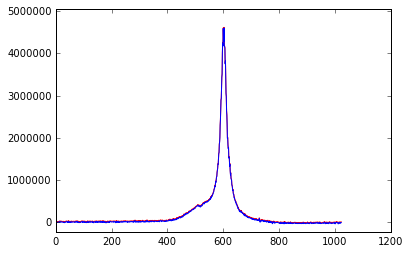

In [10]:
# Fourier Transform in F2 dimension

spec = fftpack.fft(expt, axis=1)
spec = fftpack.fftshift(spec, axes=1)


# Phase correct data and remove Bruker digitization artefacts

spec = nmrglue.process.proc_base.ps(spec, p0=-pinfo['procs']['PHC0']+0.0, p1=info['acqus']['GRPDLY']*360.0-pinfo['procs']['PHC1'], inv=False)


#Apply a simple base line correction to spectra in F2 dimension

(f1a,f2a) = expt.shape
pylab.plot(spec[0].real, 'r-');

for i in range(f1a):
    spec[i] = spec[i] - (spec[i][:100]).mean()
    
for i in range(f1a):
    spec[i] = spec[i] - (spec[i][:100]).mean()
    

pylab.plot(spec[0].real, 'b');
pylab.ylim(-0.05*spec[0].max(), 1.1*spec[0].max());
print  ((abs(spec[0][-nus_pts:].real)).sum())

In [11]:
#  Split real and imaginary

iii_cs = spec[1::2].real
rrr_cs = spec[::2].real

In [12]:
# Create real and imag data arrays and put fids in correct position and order

rrr =scipy.zeros((zerofill,f2), dtype=numpy.int32)
iii =scipy.zeros((zerofill,f2), dtype=numpy.int32)


for i,v in enumerate(cs_array):
    rrr[v] = rrr[v]+rrr_cs[i]
    iii[v] = iii[v]+iii_cs[i]

In [13]:
# find the maximum index value in the first spectrum. Value used in he thresh-holding algorihm

mp =rrr[0].argmax()
rrr = rrr.transpose()
iii = iii.transpose()

print mp

mmm_t = (rrr + 1j*iii)

603


### Perform Iterative Soft Thesholding Procedure in T$_1$ dimension

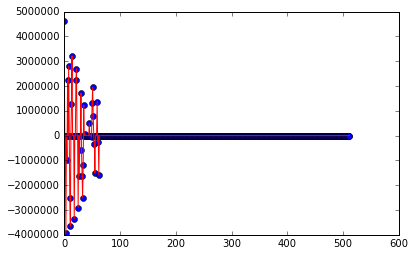

In [14]:
pylab.plot( mask*mmm_t[mp].real, 'o' );
pylab.plot( mmm_t[mp].real, 'r-' );

In [15]:

fid =  mmm_t[mp].copy()
fid0 =  mmm_t[-1].copy()
output = compressed_sensing_1D_VI( fid, mask, num_iter=500, factor=0.95, tol =0.1, maxPeaks=100)

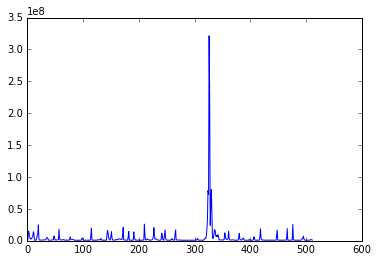

In [16]:

pylab.plot(fftshift(output[0])+40);


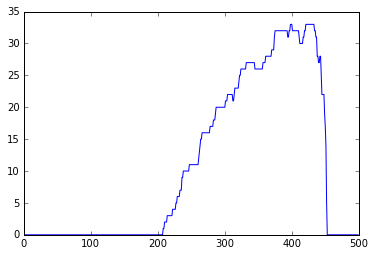

In [17]:
npeaks = scipy.array(output[1][1])
pylab.plot(npeaks);

(array([207, 209, 213, 221, 226, 228, 232, 235, 237, 246, 260, 261, 262,
       263, 265, 277, 282, 285, 286, 300, 303, 311, 313, 314, 320, 321,
       323, 331, 344, 356, 360, 369, 373, 374, 393, 395, 397, 400, 410,
       411, 416, 418, 420, 433, 435, 437, 439, 441, 443, 444, 448, 449,
       450, 451, 452], dtype=int64),)
<type 'numpy.ndarray'>
[ 2  4  8  5  2  4  3  2  9 14  1  1  1  2 12  5  3  1 14  3  8  2  1  6  1
  2  8 13 12  4  9  4  1 19  2  2  3 10  1  5  2  2 13  2  2  2  2  2  1  4
  1  1  1  1]
1 207


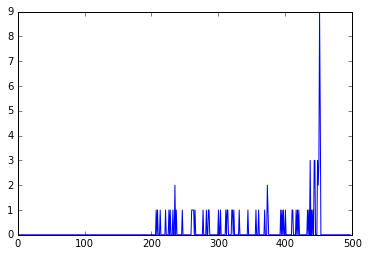

In [18]:
#print help(scipy.argsort)
sss=fftshift(output[0]).real
ddd = abs(npeaks[:]-numpy.roll(npeaks,-1))
#ddd = abs(sss[:]-numpy.roll(sss,-1))

ddd1 = ddd[:]-numpy.roll(ddd,-1)
pylab.plot((ddd[:-2]));
#pylab.plot((ddd1[:-2]));
print numpy.where(ddd[:-2])
ppp = (numpy.where(ddd[:-2]>0))[0]
print type(ppp)
print ppp[1:]-ppp[:-1]
ppp1 = ppp[1:]-ppp[:-1]


i=0
while ppp1[i] > 10:
    i += 1
    
print i+1, ppp[i]


output = compressed_sensing_1D_VI( fid, mask, num_iter=ppp[i], factor=0.95, tol =0.1, maxPeaks=i+1)

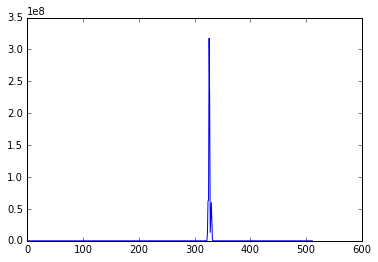

In [19]:
pylab.plot(fftshift(output[0])+40);


In [20]:
# Perform thresholding in T1 for each point

cs_spec = scipy.zeros((f2,zerofill), dtype=numpy.complex128)

stats_array = []

for j in range(f2):
    print j,

#    Y, stats = compressed_sensing_1VD( mmm_t[j], mask, num_iter=iterations, tol=1, maxPeaks=3  )    
    output = compressed_sensing_1D_VI( mmm_t[j], mask, num_iter=500, factor=0.95, tol =0.1, maxPeaks=20)
    npeaks = scipy.array(output[1][1])
    cs_spec[j] = (Y + 1j * fftpack.hilbert( Y ))
    
    sss=fftshift(output[0]).real
    ddd = abs(npeaks[:]-numpy.roll(npeaks,-1))

    ddd1 = ddd[:]-numpy.roll(ddd,-1)
#pylab.plot((ddd[:-2]));
#pylab.plot((ddd1[:-2]));
#print numpy.where(ddd[:-2])
    ppp = (numpy.where(ddd[:-2]>0))[0]
#print type(ppp)
#print ppp[1:]-ppp[:-1]
    ppp1 = ppp[1:]-ppp[:-1]


    i=0
    while ppp1[i] > 10:
        i += 1
    
#rint i+1, ppp[i]


    Y, stats = compressed_sensing_1D_VI( mmm_t[j], mask, num_iter=ppp[i], factor=0.95, tol =0.1, maxPeaks=i+1)
    cs_spec[j] = (Y + 1j * fftpack.hilbert( Y ))


0

NameError: name 'Y' is not defined

### Display Results

In [ ]:
for m in range(f2):
    cs_spec[m] = fftpack.fftshift(cs_spec[m])

In [ ]:
# Display high resolution projection 

cs_spec_sum1 = (cs_spec.real).sum(axis=1) 
#print cs_spec_sum1.max(), (cs_spec_sum[:]).sum()
ssum0 = (cs_spec.real).sum(axis=0)

pylab.plot( (cs_spec.real).sum(axis=0) );


In [ ]:
spec = fftpack.fft(mmm_t, axis=1)

In [ ]:
cs_spec_real = (cs_spec.real/10000.0)

In [ ]:
cs_spec_int32 = scipy.array(cs_spec_real, dtype=scipy.int32)

In [ ]:
pylab.plot(((cs_spec_int32).sum(axis=1)));

In [ ]:
pylab.plot( fftpack.ifft(cs_spec[mp]).real );
pylab.plot( 10*mmm_t[mp].real, 'r-' );

In [ ]:
# Arrange 2-D spectrum  in correct order for display with Bruker Topsin

cs_spec_int32 = cs_spec_int32.transpose()
cs_spec_int32 = numpy.fliplr(cs_spec_int32)
cs_spec_int32 = numpy.flipud(cs_spec_int32)

In [ ]:
cs_spec_int32 = cs_spec_int32.flatten()

In [ ]:
#Store 2-D real spectum in Bruker daa directory

fp = open( file1, 'wb' )
cs_spec_int32.tofile(fp)
fp.close()

In [ ]:
stats_array = numpy.array(stats_array)

In [ ]:
stats_array = stats_array.transpose()

In [ ]:
#final iteration value
pylab.plot( stats_array[0] ); 

In [ ]:
# final peaks found
pylab.plot( stats_array[1] ); 

In [ ]:
# final tolerance
pylab.plot( stats_array[2] ); 

In [ ]:
#file_rrr = r'Z:\Documents\work\projects\CompressedSensing\Data\eeh_20140228_diffMAT_4mmHXG\224\pdata\1'
#info,expt = nmrglue.bruker.read_pdata( file_rrr )

expt = cs_spec_real

expt = np.flipud(expt)
expt = np.fliplr(expt)
expt = expt.transpose()

In [ ]:
ppplot = TwoD_NMR_MAT_plot( expt, pinfo, info)

In [ ]:
ppplot = TwoD_NMR_MAT_plot( expt, pinfo, info, [-1,8,7,-1])

In [ ]:
print scipy.__version__
print nmrglue.__version__
print matplotlib.__version__
print numpy.__version__

In [ ]:
ppplot = TwoD_NMR_MAT_plot( expt, pinfo, info, [5,7,7,-1])